In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

d:\CS 6120\Final Project\cs6010_fa2024_project_g06\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# List of relevant columns
columns_to_use = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 
                  'trip_distance', 'fare_amount', 'total_amount']

In [4]:
df2024_1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet', columns=columns_to_use)
df2024_2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet', columns=columns_to_use)
df2024_3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet', columns=columns_to_use)
df2024_4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet', columns=columns_to_use)
df2024_5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet', columns=columns_to_use)
df2024_6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet', columns=columns_to_use)

df2024 = pd.concat([df2024_1, df2024_2, df2024_3, df2024_4, df2024_5, df2024_6])

In [5]:
df2023_1 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-01.parquet', columns=columns_to_use)
df2023_2 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-02.parquet', columns=columns_to_use)
df2023_3 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-03.parquet', columns=columns_to_use)
df2023_4 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-04.parquet', columns=columns_to_use)
df2023_5 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-05.parquet', columns=columns_to_use)
df2023_6 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-06.parquet', columns=columns_to_use)
df2023_7 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-07.parquet', columns=columns_to_use)
df2023_8 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-08.parquet', columns=columns_to_use)
df2023_9 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-09.parquet', columns=columns_to_use)
df2023_10 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-10.parquet', columns=columns_to_use)
df2023_11 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-11.parquet', columns=columns_to_use)
df2023_12 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-12.parquet', columns=columns_to_use)

In [6]:
df2023 = pd.concat([df2023_1, df2023_2, df2023_3, df2023_4, df2023_5, df2023_6, df2023_7, df2023_8, df2023_9, df2023_10, df2023_11, df2023_12])

In [7]:
df2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38310226 entries, 0 to 3376566
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   fare_amount            float64       
 5   total_amount           float64       
dtypes: datetime64[us](2), float64(4)
memory usage: 2.0 GB


In [8]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'data_type': df2023.dtypes.values,
    'null_value(%)': df2023.isna().mean().values * 100,
    'neg_value(%)': [len(df2023[col][df2023[col] < 0]) / len(df2023) * 100 if col in df2023.select_dtypes(include=[np.number]).columns else 0 for col in df2023.columns],
    '0_value(%)': [len(df2023[col][df2023[col] == 0]) / len(df2023) * 100 if col in df2023.select_dtypes(include=[np.number]).columns else 0 for col in df2023.columns],
    'duplicate' : df2023.duplicated().sum(),
    'min': [df2023[col].min() if col in df2023.select_dtypes(include=[np.number]).columns else None for col in df2023.columns],
    'max': [df2023[col].max() if col in df2023.select_dtypes(include=[np.number]).columns else None for col in df2023.columns],
    'n_unique': df2023.nunique().values,
    'sample_unique': [df2023[col].unique() for col in df2023.columns]}
).round(3)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,min,max,n_unique,sample_unique
0,tpep_pickup_datetime,datetime64[us],0.000,0.000,0.000,12,NaN,NaN,19448115,"[2023-01-01 00:32:10, 2023-01-01 00:55:08, 202..."
1,tpep_dropoff_datetime,datetime64[us],0.000,0.000,0.000,12,NaN,NaN,19438809,"[2023-01-01 00:40:36, 2023-01-01 01:01:27, 202..."
2,passenger_count,float64,3.418,0.000,1.522,12,0.00,9.00,10,"[1.0, 0.0, 4.0, 2.0, 3.0, 5.0, 6.0, 8.0, 7.0, ..."
3,trip_distance,float64,0.000,0.000,2.019,12,0.00,345729.44,8493,"[0.97, 1.1, 2.51, 1.9, 1.43, 1.84, 1.66, 11.7,..."
4,fare_amount,float64,0.000,0.996,0.034,12,-1087.30,386983.63,15122,"[9.3, 7.9, 14.9, 12.1, 11.4, 12.8, 45.7, 17.7,..."
5,total_amount,float64,0.000,0.984,0.016,12,-1094.05,386987.63,35433,"[14.3, 16.9, 34.9, 20.85, 19.68, 27.8, 20.52, ..."


### Handling Duplicates

In [9]:
df2023[df2023.duplicated()]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
934472,2023-01-11 15:50:58,2023-01-11 15:56:38,1.0,0.72,7.2,13.44
2072898,2023-03-20 06:53:45,2023-03-20 06:57:24,1.0,0.96,6.5,12.60
2274245,2023-03-22 09:39:23,2023-03-22 09:46:39,1.0,0.92,8.6,15.12
1276894,2023-06-12 16:51:28,2023-06-12 17:00:07,1.0,2.02,11.4,17.90
466543,2023-07-07 12:18:08,2023-07-07 12:18:41,1.0,0.00,3.0,4.50
1117288,2023-07-14 09:22:43,2023-07-14 09:26:09,1.0,0.40,5.8,11.75
687183,2023-09-08 12:33:01,2023-09-08 12:33:26,1.0,0.00,3.0,4.50
199209,2023-10-03 06:51:31,2023-10-03 06:58:00,1.0,0.90,7.9,14.25
1413329,2023-11-13 13:26:12,2023-11-13 14:48:41,1.0,18.87,70.0,97.13
1432572,2023-11-13 13:57:30,2023-11-13 14:54:16,1.0,18.02,70.0,85.94


In [10]:
df2023.drop_duplicates(inplace= True)

In [12]:
duplicate_value = df2023[df2023.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
132,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,-5.1,-10.1
133,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,5.1,10.1
263,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,-9.3,-14.3
264,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,9.3,14.3
324,2023-01-01 00:52:22,2023-01-01 01:14:03,1.0,4.89,-25.4,-30.4
...,...,...,...,...,...,...
3196479,2023-12-31 23:11:52,2023-12-31 23:20:02,1.0,1.44,10.7,13.2
3196508,2023-12-31 23:31:55,2023-12-31 23:57:24,1.0,0.63,-19.1,-24.1
3196509,2023-12-31 23:31:55,2023-12-31 23:57:24,1.0,0.63,19.1,24.1
3196521,2023-12-31 23:00:36,2023-12-31 23:00:43,1.0,0.00,-3.0,-8.0


In [14]:
dup_negative_val = duplicate_value[duplicate_value['fare_amount']<0]
dup_negative_val 

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
132,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,-5.1,-10.1
263,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,-9.3,-14.3
324,2023-01-01 00:52:22,2023-01-01 01:14:03,1.0,4.89,-25.4,-30.4
620,2023-01-01 00:06:39,2023-01-01 00:10:02,1.0,0.52,-5.1,-10.1
923,2023-01-01 00:34:39,2023-01-01 00:40:25,2.0,0.85,-7.2,-12.2
...,...,...,...,...,...,...
3196444,2023-12-31 23:51:34,2023-12-31 23:57:31,2.0,0.48,-5.1,-10.1
3196473,2023-12-31 23:55:57,2024-01-01 00:19:38,1.0,1.11,-19.8,-24.8
3196478,2023-12-31 23:11:52,2023-12-31 23:20:02,1.0,1.44,-10.7,-13.2
3196508,2023-12-31 23:31:55,2023-12-31 23:57:24,1.0,0.63,-19.1,-24.1


In [15]:
df2023.drop(dup_negative_val.index, inplace=True)

In [17]:
df2023[df2023.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
76201,2023-01-02 04:23:28,2023-01-02 04:23:58,3.0,0.02,0.0,1.00
76508,2023-01-02 05:12:19,2023-01-02 05:41:45,1.0,17.07,0.0,1.00
76952,2023-01-02 06:32:52,2023-01-02 07:05:44,1.0,16.71,0.0,5.25
87766,2023-01-02 11:03:12,2023-01-02 11:05:47,1.0,0.01,0.0,4.00
153088,2023-01-03 09:32:18,2023-01-03 09:32:53,1.0,0.14,0.0,2.75
...,...,...,...,...,...,...
3060020,2023-12-30 09:04:07,2023-12-30 09:11:03,1.0,0.67,0.0,4.00
3099326,2023-12-30 17:46:39,2023-12-30 17:46:50,2.0,0.01,0.0,4.00
3138529,2023-12-31 09:42:36,2023-12-31 09:43:56,2.0,0.15,0.0,4.00
3171724,2023-12-31 17:43:24,2023-12-31 17:43:33,3.0,0.00,0.0,4.00


In [18]:
df2023.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,9.30,14.30
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,14.90,34.90
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,12.10,20.85
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,11.40,19.68
5,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,12.80,27.80
...,...,...,...,...,...,...
3376562,2023-12-31 23:04:34,2023-12-31 23:13:58,NaN,1.34,12.08,16.08
3376563,2023-12-31 23:08:15,2023-12-31 23:08:23,NaN,0.00,25.98,27.48
3376564,2023-12-31 23:16:15,2023-12-31 23:30:28,NaN,3.71,16.68,18.18
3376565,2023-12-31 23:21:58,2023-12-31 23:34:29,NaN,5.20,19.64,23.64


In [ ]:
df2023[df2023.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

In [21]:
df2023 = df2023[~df2023.index.duplicated(keep='first')]

## Negative Values

In [22]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'neg_value(%)': [len(df2023[col][df2023[col] < 0]) / len(df2023) * 100 if np.issubdtype(df2023[col].dtype, np.number) else 0 for col in df2023.columns]
}).round(3)

,feature,neg_value(%)
0,tpep_pickup_datetime,0.000
1,tpep_dropoff_datetime,0.000
2,passenger_count,0.000
3,trip_distance,0.000
4,fare_amount,0.023
5,total_amount,0.009


In [23]:
negative_val  = df2023[df2023['fare_amount']<0]
df2023.loc[negative_val.index, 'fare_amount'] = df2023['fare_amount'].abs()

## Zero Values

In [25]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'data_type': df2023.dtypes.values,
    '0_value(%)': [len(df2023[col][df2023[col] == 0]) / len(df2023) * 100 if np.issubdtype(df2023[col].dtype, np.number) else 0 for col in df2023.columns]
}).round(3)

,feature,data_type,0_value(%)
0,tpep_pickup_datetime,datetime64[us],0.000
1,tpep_dropoff_datetime,datetime64[us],0.000
2,passenger_count,float64,1.586
3,trip_distance,float64,1.746
4,fare_amount,float64,0.036
5,total_amount,float64,0.018


In [27]:
median_passenger_count = df2023[df2023['passenger_count'] > 0]['passenger_count'].median()
df2023['passenger_count'] = df2023['passenger_count'].apply(lambda x: x if (x > 0 )  else median_passenger_count)

df2023 = df2023[df2023['trip_distance']>0]
df2023 = df2023[df2023['fare_amount']>0]

## Missing Values


In [28]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'data_type': df2023.dtypes.values,
    'null_value(%)': df2023.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,tpep_pickup_datetime,datetime64[us],0.0
1,tpep_dropoff_datetime,datetime64[us],0.0
2,passenger_count,float64,0.0
3,trip_distance,float64,0.0
4,fare_amount,float64,0.0
5,total_amount,float64,0.0


In [29]:
df2023['passenger_count'].fillna(df2023['passenger_count'].median(), inplace=True)
df2023['passenger_count'].value_counts()

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_12528\2750639887.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2023['passenger_count'].fillna(df2023['passenger_count'].median(), inplace=True)


passenger_count
1.0    2457408
2.0     431631
3.0     102054
4.0      51188
5.0      41306
6.0      27112
8.0          7
7.0          4
Name: count, dtype: int64

In [31]:
outliers = df2023[(df2023['tpep_pickup_datetime'].dt.year!=2023)]
outliers

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
80,2022-12-31 23:51:30,2022-12-31 23:56:06,1.0,0.86,6.5,13.50
567,2022-12-31 23:59:37,2023-01-01 00:07:28,1.0,2.38,12.1,21.38
761,2022-12-31 23:58:27,2023-01-01 00:02:21,1.0,0.49,5.8,10.88
900,2022-12-31 23:44:31,2022-12-31 23:48:47,1.0,0.52,5.8,12.96
1177,2022-12-31 23:59:25,2023-01-01 00:19:21,2.0,3.65,19.1,31.33
2172,2022-12-31 14:24:54,2022-12-31 14:35:25,1.0,0.41,10.0,15.00
2173,2022-12-31 14:39:43,2022-12-31 14:43:37,1.0,0.54,5.8,12.96
2588,2022-12-31 23:58:08,2023-01-01 00:08:28,1.0,2.83,14.2,21.12
3295,2022-12-31 23:58:59,2023-01-01 00:36:24,1.0,22.02,70.0,121.80
3517,2022-12-31 23:54:11,2023-01-01 00:02:30,2.0,0.82,8.6,15.64


In [32]:
df2023.drop(outliers.index, inplace=True)

In [33]:
df2023[(df2023['tpep_pickup_datetime'].dt.year!=2023)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount


In [34]:
time_bins = [0, 5, 11, 15, 20, 24] 
time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
df2023['pickup_time'] = pd.cut(df2023['tpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

df2023['day_category'] = df2023['tpep_pickup_datetime'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

### Trip Distance

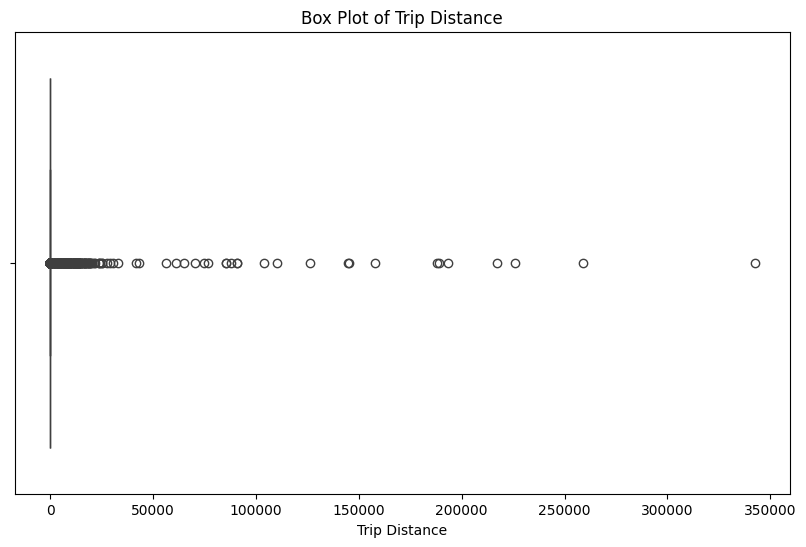

In [44]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2023['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [63]:
df2023 = df2023[df2023['trip_distance']>1]

In [64]:
df2023[df2023['trip_distance']>120].sort_values(by='trip_distance', ascending=False).shape

(0, 9)

In [65]:
df2023 = df2023[df2023['trip_distance']<120]

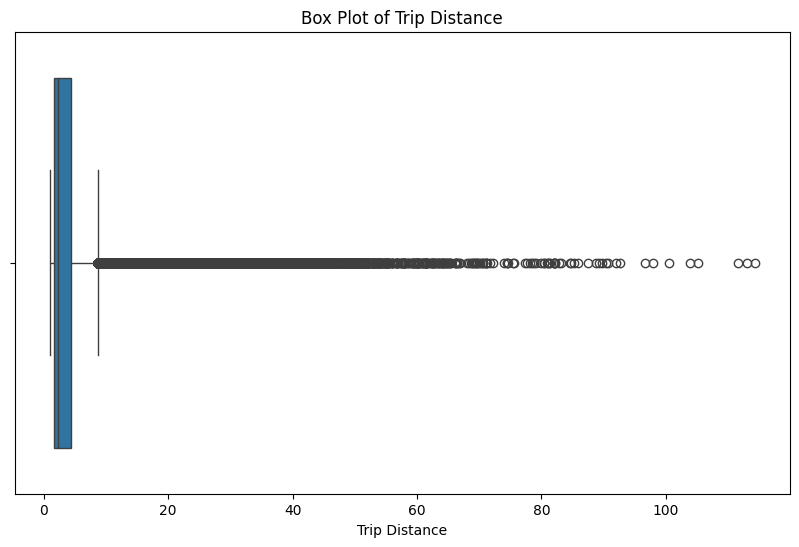

In [67]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2023['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

### Fare Amount

In [68]:
df2023[df2023['fare_amount']>120].sort_values(by='trip_distance', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,pickup_time,day_category,trip_duration
83278,2023-01-02 10:26:37,2023-01-02 12:23:13,3.0,114.27,350.0,351.00,Morning,Weekdays,116.60
1376274,2023-01-15 17:14:30,2023-01-15 19:29:10,1.0,112.97,403.4,462.45,Evening,Weekend,134.67
2901152,2023-01-31 06:43:15,2023-01-31 09:37:07,1.0,111.60,407.6,431.65,Morning,Weekdays,173.87
141672,2023-01-03 06:23:38,2023-01-03 09:23:57,1.0,105.24,390.1,400.65,Morning,Weekdays,180.32
299813,2023-01-04 20:11:27,2023-01-04 22:15:19,1.0,103.80,656.8,667.10,Night,Weekdays,123.87


### Feature Creation -- trip_duration

In [51]:
diff = (df2023['tpep_dropoff_datetime'] - df2023['tpep_pickup_datetime']).dt.total_seconds()/60
df2023['trip_duration'] = diff.round(2)

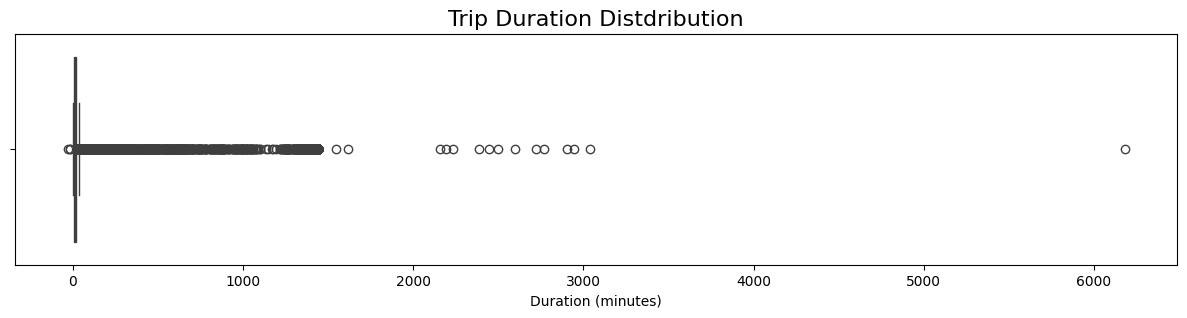

In [54]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2023, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

 With the furthest recorded distance, which is 114 miles, when traveled at the lowest average speed in New York City, which is 10 mph, the time required would be 11.4 hours (or about 684 minutes). Therefore, any trip duration exceeding this calculated time can be considered an extreme outlier, as it would be unusually long for a taxi ride. Based on this, any records with durations significantly exceeding 684 minutes can be flagged as extreme outliers, suggesting that these values are likely unnatural or erroneous.

In [70]:
df2023[df2023['trip_duration']>700].sort_values(by='trip_duration', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,pickup_time,day_category,trip_duration
1424460,2023-01-16 10:20:33,2023-01-20 17:19:57,1.0,17.69,70.0,80.55,Morning,Weekdays,6179.40
553536,2023-01-07 13:11:57,2023-01-09 15:52:28,1.0,1.86,12.8,16.80,Noon,Weekend,3040.52
894362,2023-01-11 08:34:15,2023-01-13 09:42:02,2.0,23.22,70.0,81.80,Morning,Weekdays,2947.78
2433535,2023-01-26 12:25:33,2023-01-28 12:52:30,1.0,1.04,8.6,10.10,Noon,Weekdays,2906.95
2229257,2023-01-24 13:37:01,2023-01-26 11:43:40,1.0,17.18,70.0,81.80,Noon,Weekdays,2766.65


In [71]:
df2023 = df2023[df2023['trip_duration']<700]

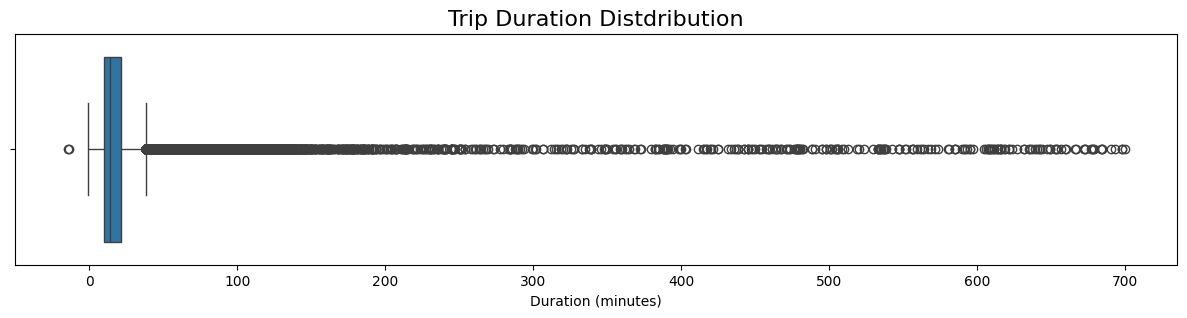

In [72]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2023, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()